Disclaimer :  This is purely an assigned research thus use this with a word of caution from my side

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import polyphase
import numpy as np
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

In [44]:
# Figuring out upper hull using the normals
from scipy.spatial import ConvexHull

def get_lower_convexhull(points):
    inf_ind = np.shape(points)[0]
    base_points = points[:,:-1].mean(axis=0)
    inf_height = 1e10*abs(max(points[:,-1]))
    p_inf = np.hstack((base_points,inf_height))
    points_inf = np.vstack((points,p_inf))
    hull = ConvexHull(points_inf)
    lower = ~(hull.simplices==inf_ind).any(axis=1)
    lower_hull = hull.simplices[lower]
    
    return lower_hull,points_inf


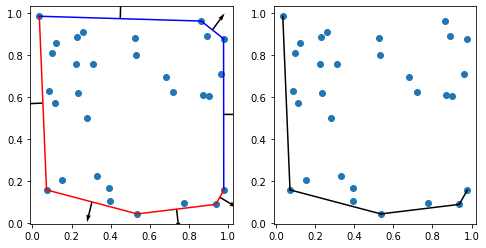

In [45]:
# 2D example of Upper Hull and Lower Hull
points = np.random.rand(30,2)

hull = ConvexHull(points)
fig, axs = plt.subplots(1,2,figsize=(2*4,4))
axs[0].plot(points[:,0], points[:,1], 'o')
for equation,simplex in zip(hull.equations,hull.simplices):
    X,Y = points[simplex].mean(axis=0)
    U,V,_ = equation
    if V>0:
        color = 'b-'
    else:
        color = 'r-'
    axs[0].plot(points[simplex, 0], points[simplex, 1], color)    
    axs[0].quiver(X,Y,U,V,scale=10,scale_units='xy')

lower_hull,_ = get_lower_convexhull(points)
axs[1].plot(points[:,0], points[:,1], 'o')
for simplex in lower_hull:
    axs[1].plot(points[simplex, 0], points[simplex, 1], 'k-')
    
plt.show()

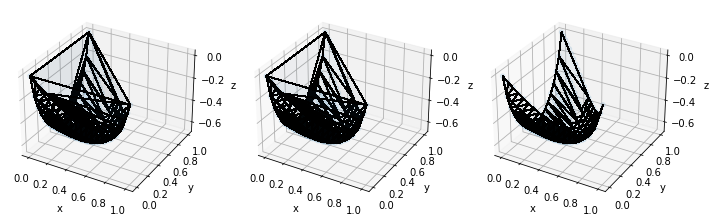

In [46]:
grid = polyphase.makegridnd(20,3)
M, chi = polyphase.get_sample_data(1)
f = lambda x : polyphase.flory_huggins(x, M, chi)
energy = np.asarray([f(x) for x in grid.T])
points = np.concatenate((grid[:-1,:].T,energy.reshape(-1,1)),axis=1)

hull = ConvexHull(points)
lower_hull, points_inf = get_lower_convexhull(points)
zlower = hull.equations[:,-2]<0

fig, axs = plt.subplots(1,3,figsize=(3*4,4),subplot_kw={'projection':'3d'})
triangles = [hull.simplices, lower_hull,hull.simplices[zlower]]
for i in range(3):
    axs[i].scatter(points[:,0], points[:,1],points[:,2],alpha=0.1)
    axs[i].plot_trisurf(points[:,0],points[:,1],points[:,2],triangles=triangles[i],
                    linewidth=1.0,edgecolor='k', antialiased=False,facecolor='grey',alpha=0.05)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_zlabel('z')
    
plt.show()

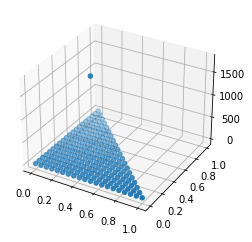

In [47]:
fig, ax = plt.subplots(subplot_kw = {'projection':'3d'})
ax.scatter(points_inf[:,0], points_inf[:,1],points_inf[:,2])
plt.show()

Computation took 5.45s


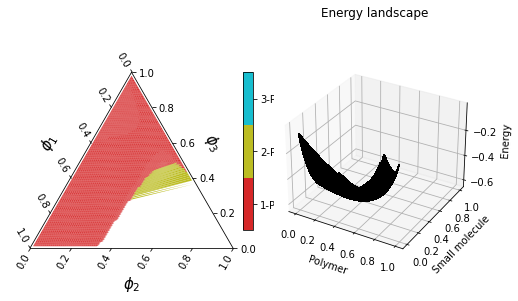

Computation took 5.33s


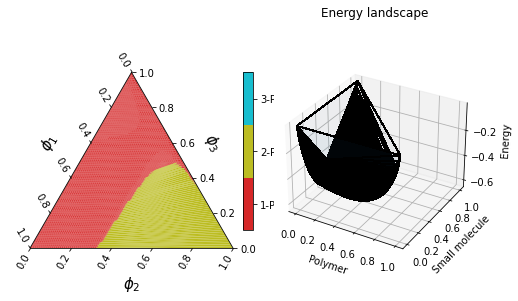

Computation took 5.19s


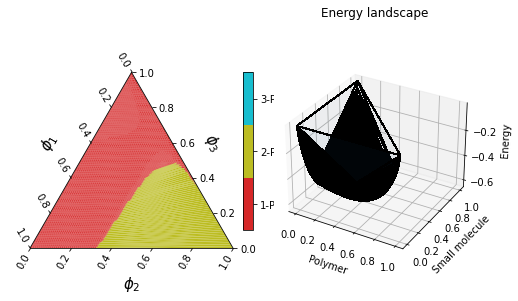

In [49]:
methods = [None, 'point_at_infinity','negative_znorm']
M, chi = polyphase.get_sample_data(1)
f = lambda x : polyphase.flory_huggins(x, M, chi)
for method in methods:
    engine = polyphase.PHASE(f,100,len(M))
    engine.compute(correction=3, lower_hull_method=method)
    renderer = polyphase.TernaryPlot(engine)
    fig = plt.figure(figsize=(2*4,4))
    ax = fig.add_subplot(1,2,1,projection='ternary')
    renderer.plot_simplices(ax=ax,label=True)
    ax = fig.add_subplot(1,2,2, projection='3d')
    polyphase.plot_energy_landscape(engine.as_dict(),mode='convex_hull',ax=ax)
    plt.show()

Computation took 2.45s
Computation took 2.27s


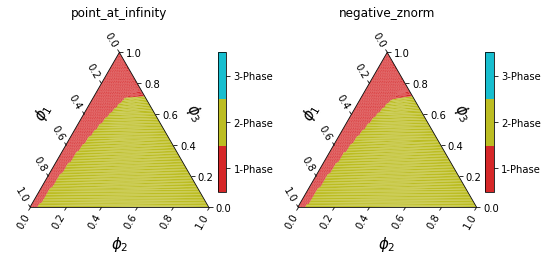

In [57]:
import pickle
import pandas as pd

dirname = '../data/hamming/pm6y6_crop'
distmats = dirname + '/distance.pkl'

with open(distmats, 'rb') as handle:
    out = pickle.load(handle)

sys_df = out['df'].reset_index(drop=True)
for _, row in sys_df[86:].iterrows():
    M = row['dop']
    chi = [row['chi12'],row['chi13'],row['chi23']]
    f = lambda x : polyphase.flory_huggins(x, M, chi)
    fig = plt.figure(figsize=(2*4,4))
    fig.subplots_adjust(wspace=0.5)
    methods = ['point_at_infinity','negative_znorm']
    for i,method in enumerate(methods):
        engine = polyphase.PHASE(f,100,len(M))
        engine.compute(correction=3, lower_hull_method=method)
        renderer = polyphase.TernaryPlot(engine)

        ax = fig.add_subplot(1,2,i+1,projection='ternary')
        renderer.plot_simplices(ax=ax,label=True)
        ax.set_title(method,pad=36)
        
    plt.show()
    break

In [ ]:
M = [1120.63, 14.40, 2.41, 1.0]
chi = [0.379,0.436,1.896, 0.583,2.393,1.320]

f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,100,len(M))
for i in [1,2,3]:
    engine.compute(correction=i,refine_simplices=False)
    engine.plot()